# Chapter 6: Learning Best Practices for Model Evaluation and Hyperparameter Tuning

## Streamlining workflows with pipelines


### Loading the Breast Cancer Wisconsin dataset

**Reading the dataset**

In [1]:
import pandas as pd
df = pd.read_csv(
'https://archive.ics.uci.edu/ml/'
'machine-learning-databases'
'/breast-cancer-wisconsin/wdbc.data',
header=None
)

**Next, we will assign the 30 features to a NumPy array, X. Using a LabelEncoder object, we will
transform the class labels from their original string representation ('M' and 'B') into integers**

In [2]:
from sklearn.preprocessing import LabelEncoder
X = df.loc[:, 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)

In [3]:
y

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,

In [4]:
le.classes_

array(['B', 'M'], dtype=object)

**The malignant tumors are now represented
as class 1, and the benign tumors are represented as class 0, respectively.** We can
double-check this mapping by calling the transform method of the fitted LabelEncoder on
two dummy class labels:


In [5]:
le.transform(['M', 'B'])

array([1, 0])

**Splitting into training and testimg sets**

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=1)
print(X_train.shape)
print(X_test.shape)

(455, 30)
(114, 30)


### Combining transformers and estimators in a pipeline

Since the features in the Breast Cancer Wisconsin dataset are measured
on various different scales, we will standardize the columns in the Breast Cancer Wisconsin dataset
before we feed them to a linear classifier, such as logistic regression. Furthermore, let’s assume that
we want to compress our data from the initial 30 dimensions into a lower two-dimensional subspace
via principal component analysis (PCA), a feature extraction technique for dimensionality reduction
that was introduced in Chapter 5.
Instead of going through the model fitting and data transformation steps for the training and test
datasets separately, we can chain the StandardScaler, PCA, and LogisticRegression objects in a
pipeline:


In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

pipr_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=2),
                        LogisticRegression(random_state=1))
pipr_lr.fit(X_train, y_train)
y_pred = pipr_lr.predict(X_test)
test_acc = pipr_lr.score(X_test, y_test)
print(f'Test Accuracy: {test_acc:.3f}')

Test Accuracy: 0.956


## Using k-fold cross validation to assess model performance

A good standard value for k in k-fold cross-validation is 10, as empirical evidence shows. For instance,
experiments by Ron Kohavi on various real-world datasets suggest that 10-fold cross-validation offers
the best tradeoff between bias and variance.

However, if we are working with relatively small training sets, it can be useful to increase the number
of folds. If we increase the value of k, more training data will be used in each iteration, which results
in a lower pessimistic bias toward estimating the generalization performance by averaging the individual
model estimates. However, large values of k will also increase the runtime of the cross-validation
algorithm and yield estimates with higher variance, since the training folds will be more similar to
each other. On the other hand, if we are working with large datasets, we can choose a smaller value
for k, for example, k = 5, and still obtain an accurate estimate of the average performance of the model
while reducing the computational cost of refitting and evaluating the model on the different folds.

A slight improvement over the standard k-fold cross-validation approach is stratified k-fold cross-validation,
which can yield better bias and variance estimates, especially in cases of unequal class proportions. In stratified cross-validation, the class label proportions are preserved in each fold to ensure
that each fold is representative of the class proportions in the training dataset, which we will illustrate
by using the StratifiedKFold iterator in scikit-learn:

In [8]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=10).split(X_train, y_train)
scores=[]
for k, (train,test) in enumerate(kfold):
    pipr_lr.fit(X_train[train], y_train[train])
    score = pipr_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print(f'Fold: {k+1:02d}, Class distr.: {np.bincount(y_train[train])}, Acc.: {score:.3f}')

Fold: 01, Class distr.: [256 153], Acc.: 0.935
Fold: 02, Class distr.: [256 153], Acc.: 0.935
Fold: 03, Class distr.: [256 153], Acc.: 0.957
Fold: 04, Class distr.: [256 153], Acc.: 0.957
Fold: 05, Class distr.: [256 153], Acc.: 0.935
Fold: 06, Class distr.: [257 153], Acc.: 0.956
Fold: 07, Class distr.: [257 153], Acc.: 0.978
Fold: 08, Class distr.: [257 153], Acc.: 0.933
Fold: 09, Class distr.: [257 153], Acc.: 0.956
Fold: 10, Class distr.: [257 153], Acc.: 0.956


In [9]:
mean_acc = np.mean(scores)
std_acc=np.std(scores)
print(f'CV accuracy: {mean_acc:.3f} +/- {std_acc:.3f}')

CV accuracy: 0.950 +/- 0.014


Although the previous code example was useful to illustrate how k-fold cross-validation works, scikitlearn
also implements a k-fold cross-validation scorer, which allows us to evaluate our model using
stratified k-fold cross-validation less verbosely:

In [11]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(estimator=pipr_lr,
                        X=X_train,
                        y=y_train,
                        cv=10,
                        n_jobs=1)
print(f'CV accuracy scores: {scores}')
print(f'CV accuracy: {np.mean(scores):.3f} +/- {np.std(scores):.3f}')

CV accuracy scores: [0.93478261 0.93478261 0.95652174 0.95652174 0.93478261 0.95555556
 0.97777778 0.93333333 0.95555556 0.95555556]
CV accuracy: 0.950 +/- 0.014


## Debugging algorithms with learning curves

### Diagnosing bias and variance problems with learning curves

In the next subsection, we will see how to address model issues using validation curves, but let’s
first see how we can use the learning curve function from scikit-learn to evaluate the model:

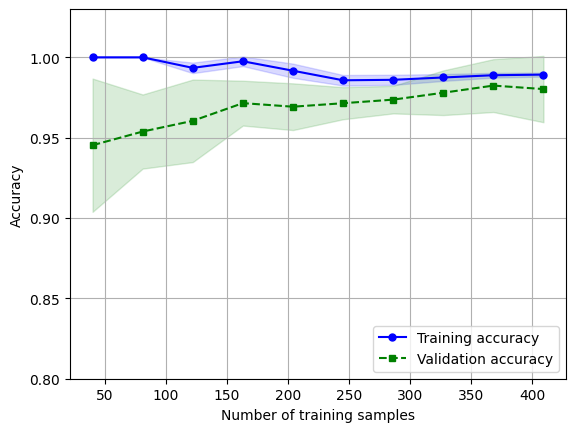

In [12]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
pipe_lr = make_pipeline(StandardScaler(),
                        LogisticRegression(penalty='l2', max_iter=10000))

train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr,
                                                        X=X_train,
                                                        y=y_train,
                                                        train_sizes=np.linspace(0.1, 1.0, 10),
                                                        cv=10,
                                                        n_jobs=1)
train_mean=np.mean(train_scores, axis=1)
train_std=np.std(train_scores, axis=1)
test_mean=np.mean(test_scores, axis=1)
test_std=np.std(test_scores, axis=1)

plt.plot(train_sizes,train_mean,color='blue',marker='o',markersize=5,label='Training accuracy')

plt.fill_between(train_sizes,train_mean+train_std,train_mean-train_std,alpha=0.15,color='blue')

plt.plot(train_sizes,test_mean,color='green',linestyle='--',marker='s',markersize=5,label='Validation accuracy')

plt.fill_between(train_sizes,test_mean+test_std,test_mean-test_std,alpha=0.15,color='green')

plt.grid(True)
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.show()

Note that we passed max_iter=10000 as an additional argument when instantiating the
LogisticRegression object (which uses 1,000 iterations as a default) to avoid convergence issues for
the smaller dataset sizes or extreme regularization parameter value

### Addressing over- and underfitting with validation curves

Let’s go ahead and see how we create validation curves via scikit-learn:

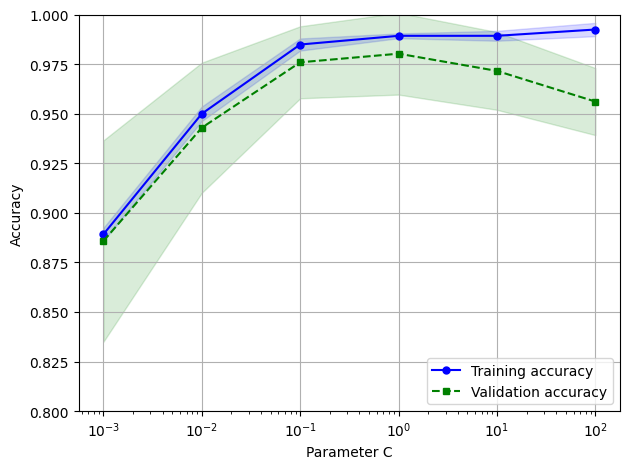

In [13]:
from sklearn.model_selection import validation_curve


param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(
                estimator=pipe_lr,
                X=X_train,
                y=y_train,
                param_name='logisticregression__C',
                param_range=param_range,
                cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

plt.plot(param_range, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

plt.fill_between(param_range,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.tight_layout()
plt.show()

Using the preceding code, we obtained the validation curve plot for the parameter C

## Fine-tuning machine learning models via grid search

### Tuning hyperparameters via grid search
The grid search approach is quite simple: it’s a brute-force exhaustive search paradigm where we specify
a list of values for different hyperparameters, and the computer evaluates the model performance
for each combination to obtain the optimal combination of values from this set:

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

pipe_svc = make_pipeline(StandardScaler(),
                         SVC(random_state=1))

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

param_grid = [{'svc__C': param_range,
               'svc__kernel': ['linear']},
              {'svc__C': param_range,
               'svc__gamma': param_range,
               'svc__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring='accuracy',
                  refit=True,
                  cv=10)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9846859903381642
{'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


Finally, we use the independent test dataset to estimate the performance of the best-selected model,
which is available via the best_estimator_ attribute of the GridSearchCV object:

In [15]:
clf = gs.best_estimator_

# clf.fit(X_train, y_train)
# note that we do not need to refit the classifier
# because this is done automatically via refit=True.

print(f'Test accuracy: {clf.score(X_test, y_test):.3f}')

Test accuracy: 0.974


### Exploring hyperparameter configurations more widely with randomized search

Note that while RandomizedSearchCV can accept similar discrete lists of values as inputs for the parameter
grid, which is useful when considering categorical hyperparameters, its main power lies in
the fact that we can replace these lists with distributions to sample from. Thus, for example, we may
substitute the preceding list with the following distribution from SciPy:


In [26]:
import scipy
param_range_scipy = scipy.stats.loguniform(0.0001, 1000.0)
print(param_range_scipy.rvs(10))

[1.92345462e+00 8.96534676e+02 3.03398728e-04 2.32536728e+02
 2.27773481e+00 7.90115637e+01 9.51906498e-03 2.25558566e-03
 2.33395892e-04 1.48075782e+00]


For instance, using a loguniform distribution instead of a regular uniform distribution will ensure
that in a sufficiently large number of trials, the same number of samples will be drawn from the
[0.0001, 0.001] range as, for example, the [10.0, 100.0] range. To check its behavior, we can draw 10
random samples from this distribution via the rvs(10) method, as shown here

In [16]:
from sklearn.model_selection import RandomizedSearchCV


pipe_svc = make_pipeline(
    StandardScaler(),
    SVC(random_state=1))

param_grid = [{'svc__C': param_range,
               'svc__kernel': ['linear']},
              {'svc__C': param_range,
               'svc__gamma': param_range,
               'svc__kernel': ['rbf']}]


rs = RandomizedSearchCV(estimator=pipe_svc,
                        param_distributions=param_grid,
                        scoring='accuracy',
                        refit=True,
                        n_iter=20,
                        cv=10,
                        random_state=1,
                        n_jobs=-1)

Based on this code example, we can see that the usage is very similar to GridSearchCV, except that we
could use distributions for specifying parameter ranges and specified the number of iterations—20
iterations—by setting n_iter=20.

### More resource-efficient hyperparameter search with successive halving
Taking the idea of randomized search one step further, scikit-learn implements a successive halving
variant, HalvingRandomSearchCV, that makes finding suitable hyperparameter configurations more
efficient. Successive halving, given a large set of candidate configurations, successively throws out
unpromising hyperparameter configurations until only one configuration remains. We can summarize
the procedure via the following steps:
1. Draw a large set of candidate configurations via random sampling
2. Train the models with limited resources, for example, a small subset of the training data (as
opposed to using the entire training set)
3. Discard the bottom 50 percent based on predictive performance
4. Go back to step 2 with an increased amount of available resources



The steps are repeated until only one hyperparameter configuration remains.
We can use randomized search with successive halving as
shown in the following:

In [21]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

hs = HalvingRandomSearchCV(
    pipe_svc,
    param_distributions=param_grid,
    n_candidates='exhaust',
    resource='n_samples',
    factor=1.5,
    random_state=1,
    n_jobs=-1)

The resource='n_samples' (default) setting specifies that we consider the training set size as the resource
we vary between the rounds. Via the factor parameter, we can determine how many candidates
are eliminated in each round. For example, setting factor=2 eliminates half of the candidates, and setting
factor=1.5 means that only 100%/1.5 ≈ 66% of the candidates make it into the next round. Instead
of choosing a fixed number of iterations as in RandomizedSearchCV, we set n_candidates='exhaust'
(default), which will sample the number of hyperparameter configurations such that the maximum
number of resources (here: training examples) are used in the last round.

We can then carry out the search similar to RandomizedSearchCV:

In [22]:
hs = hs.fit(X_train, y_train)
print(hs.best_score_)
print(hs.best_params_)

0.9676470588235293
{'svc__kernel': 'rbf', 'svc__gamma': 0.0001, 'svc__C': 100.0}


In [23]:
clf = hs.best_estimator_
print(f'Test accuracy: {hs.score(X_test, y_test):.3f}')

Test accuracy: 0.965


### Algorithm selection with nested cross-validation

Using k-fold cross-validation in combination with grid search or randomized search is a useful approach
for fine-tuning the performance of a machine learning model by varying its hyperparameter
values, as we saw in the previous subsections. If we want to select among different machine
learning algorithms, though, another recommended approach is nested cross-validation.

In nested cross-validation, we have an outer k-fold cross-validation loop to split the data into training
and test folds, and an inner loop is used to select the model using k-fold cross-validation on the training
fold. After model selection, the test fold is then used to evaluate the model performance.

In scikit-learn, we can perform nested cross-validation with grid search as follows:

In [24]:
param_range = [0.0001,0.001,0.01,0.1,1.0,10.0,100.0,1000.0]
param_grid = [{'svc__C': param_range,
               'svc__kernel': ['linear']},
              {'svc__C': param_range,
               'svc__gamma': param_range,
               'svc__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=2)

scores = cross_val_score(gs, X_train, y_train,
                         scoring='accuracy', cv=5)
print(f'CV accuracy: {np.mean(scores):.3f} '
      f'+/- {np.std(scores):.3f}')

CV accuracy: 0.974 +/- 0.015


The returned average cross-validation accuracy gives us a good estimate of what to expect if we tune
the hyperparameters of a model and use it on unseen data.


For example, we can use the nested cross-validation approach to compare an SVM model to a simple
decision tree classifier; for simplicity, we will only tune its depth parameter:

In [25]:
from sklearn.tree import DecisionTreeClassifier
gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
                  param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}],
                  scoring='accuracy',
                  cv=2)

scores = cross_val_score(gs, X_train, y_train,
                         scoring='accuracy', cv=5)
print(f'CV accuracy: {np.mean(scores):.3f} '
      f'+/- {np.std(scores):.3f}')

CV accuracy: 0.934 +/- 0.016


As we can see, the nested cross-validation performance of the SVM model (97.4 percent) is notably
better than the performance of the decision tree (93.4 percent), and thus, we’d expect that it might be
the better choice to classify new data that comes from the same population as this particular dataset.

## Looking at different performance evaluation metrics

### Reading a confusion matrix

A confusion matrix is simply a square matrix that reports the counts of the true positive (TP), true negative
(TN), false positive (FP), and false negative (FN) predictions of a classifier, as shown in Figure:

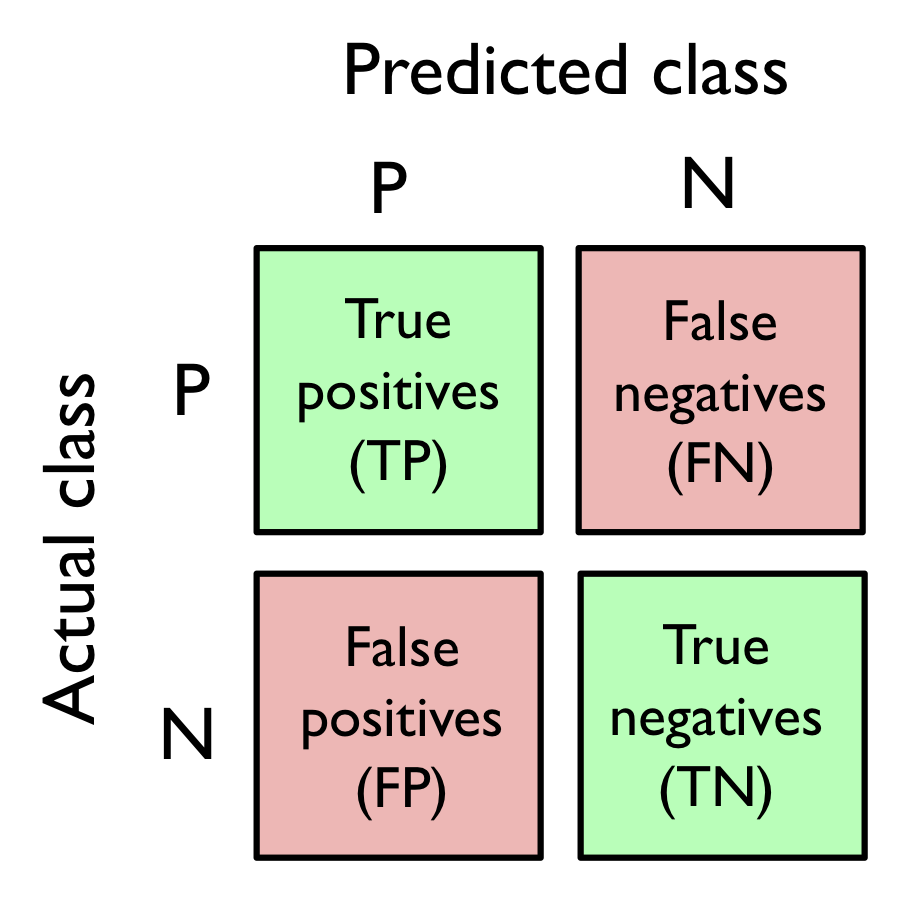

In [27]:
from IPython.display import Image
Image(filename='/content/drive/MyDrive/Colab Notebooks/ML Book/Ch06/06_08.png', width=300)

Although these metrics can be easily computed manually by comparing the actual and predicted class
labels, scikit-learn provides a convenient confusion_matrix function that we can use, as follows

In [28]:
from sklearn.metrics import confusion_matrix
pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(conf_mat)

[[71  1]
 [ 2 40]]


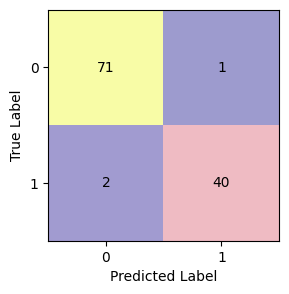

In [31]:
# Using matplotlib
fig,ax = plt.subplots(figsize=(3,3))
ax.matshow(conf_mat,cmap=plt.cm.plasma,alpha=0.4)
for i in range(conf_mat.shape[0]):
    for j in range(conf_mat.shape[1]):
        ax.text(x=j,y=i,s=conf_mat[i,j],va='center',ha='center')

ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
plt.show()

Assuming that class 1 (malignant) is the positive class in this example, our model correctly classified
71 of the examples that belong to class 0 (TN) and 40 examples that belong to class 1 (TP), respectively.
However, our model also incorrectly misclassified two examples from class 1 as class 0 (FN), and it
predicted that one example is malignant although it is a benign tumor (FP). In the next subsection,
we will learn how we can use this information to calculate various error metrics.

### Optimizing the precision and recall of a classification model

All scoring metrics are all implemented in scikit-learn and can be imported from the sklearn.
metrics module as shown in the following snippet:

In [32]:
from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef

pre_val=precision_score(y_true=y_test, y_pred=y_pred)
rec_val=recall_score(y_true=y_test, y_pred=y_pred)
f1_val=f1_score(y_true=y_test, y_pred=y_pred)
mcc_val=matthews_corrcoef(y_true=y_test, y_pred=y_pred)
print(f'Precision: {pre_val:.3f}')
print(f'Recall: {rec_val:.3f}')
print(f'F1: {f1_val:.3f}')
print(f'MCC: {mcc_val:.3f}')

Precision: 0.976
Recall: 0.952
F1: 0.964
MCC: 0.943


Furthermore, we can use a different scoring metric than accuracy in the GridSearchCV via the scoring
parameter.

Remember that the positive class in scikit-learn is the class that is labeled as class 1. If we want to
specify a different positive label, we can construct our own scorer via the make_scorer function, which
we can then directly provide as an argument to the scoring parameter in GridSearchCV (in this example,
using the f1_score as a metric):

In [33]:
from sklearn.metrics import make_scorer
c_gamma_range = [0.01,0.1,1.0,10.0]
param_grid = [{'svc__C': c_gamma_range,
               'svc__kernel': ['linear']},
              {'svc__C': c_gamma_range,
               'svc__gamma': c_gamma_range,
               'svc__kernel': ['rbf']}]

scorer = make_scorer(f1_score, pos_label=0)

gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring=scorer,
                  cv=10)

gs.fit(X_train,y_train)
print(f'Best score: {gs.best_score_:.3f}')
print(f'Best params: {gs.best_params_}')

Best score: 0.986
Best params: {'svc__C': 10.0, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}


### Plotting a receiver operating characteristic - ROC
Receiver operating characteristic (ROC) graphs are useful tools to select models for classification
based on their performance with respect to the FPR and TPR, which are computed by shifting the
decision threshold of the classifier. The diagonal of a ROC graph can be interpreted as random guessing,
and classification models that fall below the diagonal are considered as worse than random guessing.
A perfect classifier would fall into the top-left corner of the graph with a TPR of 1 and an FPR of 0.
Based on the ROC curve, we can then compute the so-called ROC area under the curve (ROC AUC) to
characterize the performance of a classification model.

Executing the following code example, we will plot a ROC curve of a classifier that only uses two features
from the Breast Cancer Wisconsin dataset to predict whether a tumor is benign or malignant.
Although we are going to use the same logistic regression pipeline that we defined previously, we
are only using two features this time. This is to make the classification task more challenging for the
classifier, by withholding useful information contained in the other features, so that the resulting
ROC curve becomes visually more interesting. For similar reasons, we are also reducing the number
of folds in the StratifiedKFold validator to three. The code is as follows:

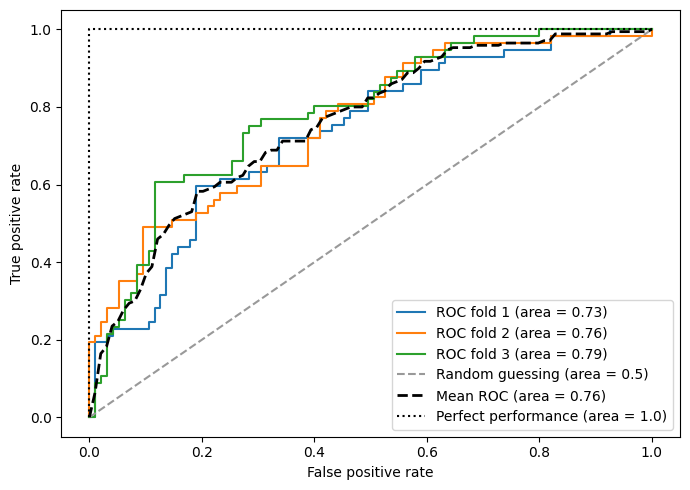

In [34]:
from sklearn.metrics import roc_curve, auc
from numpy import interp


pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=2),
                        LogisticRegression(penalty='l2',
                                           random_state=1,
                                           solver='lbfgs',
                                           C=100.0))

X_train2 = X_train[:, [4, 14]]


cv = list(StratifiedKFold(n_splits=3).split(X_train, y_train))

fig = plt.figure(figsize=(7, 5))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(X_train2[train],
                         y_train[train]).predict_proba(X_train2[test])

    fpr, tpr, thresholds = roc_curve(y_train[test],
                                     probas[:, 1],
                                     pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,
             tpr,
             label=f'ROC fold {i+1} (area = {roc_auc:.2f})')

plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color=(0.6, 0.6, 0.6),
         label='Random guessing (area = 0.5)')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label=f'Mean ROC (area = {mean_auc:.2f})', lw=2)
plt.plot([0, 0, 1],
         [0, 1, 1],
         linestyle=':',
         color='black',
         label='Perfect performance (area = 1.0)')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

In the preceding code example, we used the already familiar StratifiedKFold class from scikit-learn
and calculated the ROC performance of the LogisticRegression classifier in our pipe_lr pipeline
using the roc_curve function from the sklearn.metrics module separately for each iteration. Furthermore,
we interpolated the average ROC curve from the three folds via the interp function that we
imported from SciPy and calculated the area under the curve via the auc function. The resulting ROC
curve indicates that there is a certain degree of variance between the different folds, and the average
ROC AUC (0.76) falls between a perfect score (1.0) and random guessing (0.5)

### The scoring metrics for multiclass classification

In [35]:
pre_scorer = make_scorer(score_func=precision_score,
                         pos_label=1,
                         greater_is_better=True,
                         average='micro')

### Dealing with class imbalance

Imagine that the Breast Cancer Wisconsin dataset that we’ve been working with in this chapter consisted
of 90 percent healthy patients. In this case, we could achieve 90 percent accuracy on the test
dataset by just predicting the majority class (benign tumor) for all examples, without the help of a
supervised machine learning algorithm. Thus, training a model on such a dataset that achieves approximately
90 percent test accuracy would mean our model hasn’t learned anything useful from the
features provided in this dataset.


In this section, we will briefly go over some of the techniques that could help with imbalanced datasets.
But before we discuss different methods to approach this problem, let’s create an imbalanced
dataset from our dataset, which originally consisted of 357 benign tumors (class 0) and 212 malignant
tumors (class 1):


In [36]:
X_imb = np.vstack((X[y == 0], X[y == 1][:40]))
y_imb = np.hstack((y[y == 0], y[y == 1][:40]))

In this code snippet, we took all 357 benign tumor examples and stacked them with the first 40 malignant
examples to create a stark class imbalance. If we were to compute the accuracy of a model
that always predicts the majority class (benign, class 0), we would achieve a prediction accuracy of
approximately 90 percent:

In [37]:
y_pred = np.zeros(y_imb.shape[0])
np.mean(y_pred == y_imb) * 100

89.92443324937027

Thus, when we fit classifiers on such datasets, it would make sense to focus on other metrics than
accuracy when comparing different models, such as precision, recall, the ROC curve—whatever we
care most about in our application. For instance, our priority might be to identify the majority of patients
with malignant cancer to recommend an additional screening, so recall should be our metric of
choice. In spam filtering, where we don’t want to label emails as spam if the system is not very certain,
precision might be a more appropriate metric.

One way to deal with imbalanced class proportions during model fitting is to assign a larger penalty
to wrong predictions on the minority class. Via scikit-learn, adjusting such a penalty is as convenient
as setting the `class_weight` parameter to `class_weight='balanced'`, which is implemented for most
classifiers.

Other popular strategies for dealing with class imbalance include upsampling the minority class,
downsampling the majority class, and the generation of synthetic training examples. Unfortunately,
there’s no universally best solution or technique that works best across different problem domains.
Thus, in practice, it is recommended to try out different strategies on a given problem, evaluate the
results, and choose the technique that seems most appropriate.

The scikit-learn library implements a simple resample function that can help with the upsampling of
the minority class by drawing new samples from the dataset with replacement. The following code
will take the minority class from our imbalanced Breast Cancer Wisconsin dataset (here, class 1) and
repeatedly draw new samples from it until it contains the same number of examples as class label 0:

In [38]:
from sklearn.utils import resample
print("Number of class 1 example before: ", X_imb[y_imb == 1].shape[0])
X_upsampled, y_upsampled = resample(
    X_imb[y_imb == 1],
    y_imb[y_imb == 1],
    replace=True, n_samples=X_imb[y_imb == 0].shape[0],
    random_state=123)
print("Number of class 1 example after: ", X_upsampled.shape[0])

Number of class 1 example before:  40
Number of class 1 example after:  357


After resampling, we can then stack the original class 0 samples with the upsampled class 1 subset to
obtain a balanced dataset as follows:

In [39]:
X_bal = np.vstack((X[y == 0], X_upsampled))
y_bal = np.hstack((y[y == 0], y_upsampled))

Consequently, a majority vote prediction rule would only achieve 50 percent accuracy:

In [40]:
y_pred = np.zeros(y_bal.shape[0])
np.mean(y_pred == y_bal) * 100

50.0

Similarly, we could downsample the majority class by removing training examples from the dataset.
To perform downsampling using the resample function, we could simply swap the class 1 label with
class 0 in the previous code example and vice versa